In [1]:
# Import các thư viện cần thiết
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Thiết lập seed để đảm bảo tính tái lập
seed = 1
torch.manual_seed(seed)

# Import thêm các module hỗ trợ từ PyTorch
from torch.utils.data import Dataset, DataLoader


In [2]:
# Đường dẫn tới file CSV
dataset_filepath = '/content/weatherHistory.csv'

# Đọc dữ liệu từ file CSV
df = pd.read_csv(dataset_filepath)

# Lấy cột 'Temperature (C)' làm dữ liệu univariate (dữ liệu 1 biến)
univariate_df = df['Temperature (C)']

# Thiết lập cột 'Formatted Date' làm index cho DataFrame
univariate_df.index = pd.to_datetime(df['Formatted Date'])


<ipython-input-2-c5c9308668c7>:11: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  univariate_df.index = pd.to_datetime(df['Formatted Date'])


In [3]:
# Hiển thị 5 dòng đầu tiên sau khi xử lý
print(univariate_df.head())


Formatted Date
2006-04-01 00:00:00+02:00    9.472222
2006-04-01 01:00:00+02:00    9.355556
2006-04-01 02:00:00+02:00    9.377778
2006-04-01 03:00:00+02:00    8.288889
2006-04-01 04:00:00+02:00    8.755556
Name: Temperature (C), dtype: float64


In [4]:
# Kích thước cửa sổ đầu vào và nhãn
input_size = 6      # Số bước thời gian đầu vào (6 giờ trước)
label_size = 1      # Số bước thời gian đầu ra (1 giờ sau)
offset = 1          # Khoảng cách giữa đầu vào và đầu ra

# Hàm tạo cửa sổ dữ liệu
def slicing_window(df, df_start_idx, df_end_idx, input_size, label_size, offset):
    """
    Hàm tạo cửa sổ dữ liệu để chia thành input (features) và output (labels).

    Args:
        df (numpy array): Dữ liệu thời gian gốc.
        df_start_idx (int): Vị trí bắt đầu lấy dữ liệu.
        df_end_idx (int): Vị trí kết thúc lấy dữ liệu (nếu None sẽ tự tính).
        input_size (int): Kích thước đầu vào (số bước thời gian).
        label_size (int): Kích thước đầu ra (số bước thời gian).
        offset (int): Khoảng cách giữa đầu vào và đầu ra.

    Returns:
        tuple: (features, labels) - mảng đầu vào và đầu ra.
    """
    features = []  # Danh sách lưu các cửa sổ đầu vào
    labels = []    # Danh sách lưu các nhãn đầu ra

    # Tổng kích thước cửa sổ
    window_size = input_size + offset

    # Nếu df_end_idx không được cung cấp, tính giá trị mặc định
    if df_end_idx is None:
        df_end_idx = len(df) - window_size

    # Tạo cửa sổ dữ liệu
    for idx in range(df_start_idx, df_end_idx):
        feature_end_idx = idx + input_size  # Vị trí kết thúc của đầu vào
        label_start_idx = idx + window_size - label_size  # Vị trí bắt đầu của nhãn

        feature = df[idx:feature_end_idx]  # Lấy đầu vào
        label = df[label_start_idx:(idx + window_size)]  # Lấy nhãn

        features.append(feature)
        labels.append(label)

    # Chuyển đổi danh sách thành mảng numpy
    features = np.expand_dims(np.array(features), -1)  # Thêm trục thứ 3
    labels = np.array(labels)

    return features, labels


In [5]:
# Độ dài của tập dữ liệu
dataset_length = len(univariate_df)

# Tỉ lệ chia dữ liệu
train_size = 0.7  # 70% cho tập huấn luyện
val_size = 0.2    # 20% cho tập validation

# Tính chỉ số kết thúc cho tập train và val
train_end_idx = int(train_size * dataset_length)  # Vị trí cuối của tập train
val_end_idx = int(val_size * dataset_length) + train_end_idx  # Vị trí cuối của tập val

# Chia dữ liệu cho tập train
X_train, y_train = slicing_window(
    univariate_df.values,   # Chuyển DataFrame thành numpy array
    df_start_idx=0,
    df_end_idx=train_end_idx,
    input_size=input_size,
    label_size=label_size,
    offset=offset
)

# Chia dữ liệu cho tập validation
X_val, y_val = slicing_window(
    univariate_df.values,
    df_start_idx=train_end_idx,
    df_end_idx=val_end_idx,
    input_size=input_size,
    label_size=label_size,
    offset=offset
)

# Chia dữ liệu cho tập test
X_test, y_test = slicing_window(
    univariate_df.values,
    df_start_idx=val_end_idx,
    df_end_idx=None,  # Lấy tới cuối dữ liệu
    input_size=input_size,
    label_size=label_size,
    offset=offset
)

# Kiểm tra kích thước dữ liệu
print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)


Training set: (67517, 6, 1) (67517, 1)
Validation set: (19290, 6, 1) (19290, 1)
Test set: (9639, 6, 1) (9639, 1)


In [6]:
class WeatherForecast(Dataset):
    """
    Dataset tùy chỉnh cho bài toán dự đoán nhiệt độ.
    """

    def __init__(self, X, y, transform=None):
        """
        Khởi tạo dataset.

        Args:
            X (numpy array): Dữ liệu đầu vào (features).
            y (numpy array): Dữ liệu nhãn (labels).
            transform (function): Hàm chuyển đổi (nếu có).
        """
        self.X = X  # Lưu trữ dữ liệu đầu vào
        self.y = y  # Lưu trữ nhãn
        self.transform = transform  # Hàm chuyển đổi tùy chọn

    def __len__(self):
        """
        Trả về số lượng mẫu trong dataset.
        """
        return len(self.X)

    def __getitem__(self, idx):
        """
        Lấy một mẫu dữ liệu tại vị trí idx.

        Args:
            idx (int): Chỉ số của mẫu cần lấy.

        Returns:
            tuple: (X, y) - Dữ liệu đầu vào và nhãn đã chuyển đổi thành tensor.
        """
        X = self.X[idx]  # Lấy dữ liệu đầu vào
        y = self.y[idx]  # Lấy nhãn tương ứng

        # Áp dụng hàm transform nếu được cung cấp
        if self.transform:
            X = self.transform(X)

        # Chuyển đổi dữ liệu thành tensor
        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)

        return X, y


In [8]:
# Tạo dataset cho từng tập (train, validation, test)
train_dataset = WeatherForecast(X_train, y_train)  # Tập huấn luyện
val_dataset = WeatherForecast(X_val, y_val)        # Tập validation
test_dataset = WeatherForecast(X_test, y_test)     # Tập kiểm tra

# Đặt kích thước batch
train_batch_size = 128  # Số lượng mẫu trong mỗi batch cho train
test_batch_size = 8     # Số lượng mẫu trong mỗi batch cho validation và test

# Tạo DataLoader cho tập huấn luyện
train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,  # Kích thước batch
    shuffle=True                 # Trộn dữ liệu (phù hợp cho huấn luyện)
)

# Tạo DataLoader cho tập validation
val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,  # Kích thước batch
    shuffle=False                # Không trộn dữ liệu
)

# Tạo DataLoader cho tập kiểm tra
test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,  # Kích thước batch
    shuffle=False                # Không trộn dữ liệu
)


In [9]:
class WeatherForecastor(nn.Module):
    """
    Mô hình RNN cho bài toán dự đoán thời gian (Time Series Forecasting).
    """

    def __init__(self, embedding_dim, hidden_size, n_layers, dropout_prob):
        """
        Khởi tạo mô hình.

        Args:
            embedding_dim (int): Kích thước đầu vào (số chiều embedding).
            hidden_size (int): Số chiều của hidden state trong RNN.
            n_layers (int): Số lớp RNN.
            dropout_prob (float): Xác suất dropout.
        """
        super(WeatherForecastor, self).__init__()
        self.rnn = nn.RNN(embedding_dim, hidden_size, n_layers, batch_first=True)
        self.norm = nn.LayerNorm(hidden_size)  # Layer normalization cho ổn định
        self.dropout = nn.Dropout(dropout_prob)  # Dropout để tránh overfitting
        self.fc = nn.Linear(hidden_size, 1)  # Fully connected layer cho đầu ra

    def forward(self, x):
        """
        Hàm chuyển tiếp dữ liệu qua mô hình.

        Args:
            x (Tensor): Input tensor có dạng (batch_size, seq_len, embedding_dim).

        Returns:
            Tensor: Output tensor có dạng (batch_size, 1).
        """
        x, hn = self.rnn(x)  # RNN trả về (tất cả hidden states, final hidden state)
        x = x[:, -1, :]  # Lấy hidden state cuối cùng (h_t) từ chuỗi đầu vào
        x = self.norm(x)  # Layer normalization
        x = self.dropout(x)  # Dropout
        x = self.fc(x)  # Fully connected layer để dự đoán đầu ra
        return x


In [10]:
# Cấu hình tham số cho mô hình
embedding_dim = 1       # Số chiều đầu vào (vì chỉ có 1 đặc trưng: Temperature)
hidden_size = 8         # Số chiều của hidden state trong RNN
n_layers = 3            # Số lớp RNN
dropout_prob = 0.2      # Xác suất dropout để tránh overfitting
device = 'cuda' if torch.cuda.is_available() else 'cpu'  # Sử dụng GPU nếu có, nếu không dùng CPU

# Khởi tạo mô hình WeatherForecastor và chuyển lên thiết bị (GPU/CPU)
model = WeatherForecastor(
    embedding_dim=embedding_dim,
    hidden_size=hidden_size,
    n_layers=n_layers,
    dropout_prob=dropout_prob
).to(device)

# In cấu trúc mô hình
print(model)


WeatherForecastor(
  (rnn): RNN(1, 8, num_layers=3, batch_first=True)
  (norm): LayerNorm((8,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=8, out_features=1, bias=True)
)


In [11]:
# Learning rate và số epochs
lr = 1e-3  # Tốc độ học
epochs = 50  # Số lần lặp qua toàn bộ tập dữ liệu

# Hàm mất mát (Loss function)
criterion = nn.MSELoss()  # Sử dụng Mean Squared Error (MSE) cho bài toán hồi quy

# Optimizer (Adam)
optimizer = torch.optim.Adam(
    model.parameters(),  # Các tham số của mô hình cần tối ưu hóa
    lr=lr  # Learning rate
)

# In thông tin cấu hình
print(f"Learning Rate: {lr}")
print(f"Number of Epochs: {epochs}")
print(f"Loss Function: {criterion}")
print(f"Optimizer: {optimizer}")


Learning Rate: 0.001
Number of Epochs: 50
Loss Function: MSELoss()
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


In [13]:
def fit(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    """
    Hàm huấn luyện mô hình.

    Args:
        model (nn.Module): Mô hình cần huấn luyện.
        train_loader (DataLoader): Bộ dữ liệu huấn luyện.
        val_loader (DataLoader): Bộ dữ liệu validation.
        criterion (nn.Module): Hàm mất mát.
        optimizer (torch.optim): Bộ tối ưu hóa.
        device (str): Thiết bị ('cuda' hoặc 'cpu').
        epochs (int): Số lượng epochs.

    Returns:
        tuple: train_losses, val_losses - danh sách loss trong mỗi epoch.
    """
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []
        model.train()  # Chuyển mô hình sang chế độ train

        for idx, (inputs, labels) in enumerate(train_loader):
            # Đưa dữ liệu vào device
            inputs, labels = inputs.to(device), labels.to(device)

            # Đặt lại gradient
            optimizer.zero_grad()

            # Tính toán đầu ra và loss
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Lan truyền ngược (backpropagation) và cập nhật trọng số
            loss.backward()
            optimizer.step()

            # Ghi lại giá trị loss
            batch_train_losses.append(loss.item())

        # Tính toán loss trung bình cho epoch
        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        # Đánh giá mô hình trên tập validation
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)

        # In thông tin về epoch
        print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}\tVal acc: {val_acc:.4f}')

    return train_losses, val_losses


In [14]:
def evaluate(model, dataloader, criterion, device):
    """
    Hàm đánh giá mô hình trên tập dữ liệu.

    Args:
        model (nn.Module): Mô hình cần đánh giá.
        dataloader (DataLoader): Bộ dữ liệu validation hoặc test.
        criterion (nn.Module): Hàm mất mát.
        device (str): Thiết bị ('cuda' hoặc 'cpu').

    Returns:
        tuple: (loss trung bình, độ chính xác).
    """
    model.eval()  # Chuyển mô hình sang chế độ đánh giá (tắt dropout, batchnorm)
    correct = 0  # Số lượng dự đoán đúng
    total = 0  # Tổng số mẫu dữ liệu
    losses = []  # Danh sách lưu các giá trị loss

    with torch.no_grad():  # Tắt tính toán gradient để tiết kiệm tài nguyên
        for inputs, labels in dataloader:
            # Chuyển dữ liệu và nhãn sang thiết bị (GPU hoặc CPU)
            inputs, labels = inputs.to(device), labels.to(device)

            # Dự đoán đầu ra của mô hình
            outputs = model(inputs)

            # Tính toán hàm mất mát
            loss = criterion(outputs, labels)
            losses.append(loss.item())  # Lưu giá trị loss của batch

            # Lấy dự đoán nhãn bằng cách chọn giá trị lớn nhất
            _, predicted = torch.max(outputs.data, 1)

            # Tính tổng số mẫu và số lượng dự đoán đúng
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Tính loss trung bình cho toàn bộ tập dữ liệu
    loss = sum(losses) / len(losses)

    # Tính độ chính xác (số dự đoán đúng / tổng số mẫu)
    acc = correct / total

    return loss, acc  # Trả về loss trung bình và độ chính xác


In [15]:
# Thực hiện huấn luyện mô hình
train_losses, val_losses = fit(
    model=model,           # Mô hình dự báo thời tiết (WeatherForecastor)
    train_loader=train_loader,  # DataLoader cho tập huấn luyện
    val_loader=val_loader,      # DataLoader cho tập validation
    criterion=criterion,    # Hàm mất mát (MSELoss)
    optimizer=optimizer,    # Optimizer (Adam)
    device=device,          # Thiết bị (CPU hoặc GPU)
    epochs=epochs           # Số lượng epochs
)

# In thông tin huấn luyện hoàn tất
print("Training completed!")
print(f"Train Losses: {train_losses}")
print(f"Validation Losses: {val_losses}")


EPOCH 1:	Train loss: 126.5260	Val loss: 40.6979	Val acc: 0.0054
EPOCH 2:	Train loss: 29.9595	Val loss: 7.4822	Val acc: 0.0054
EPOCH 3:	Train loss: 16.1813	Val loss: 3.5673	Val acc: 0.0054
EPOCH 4:	Train loss: 13.1765	Val loss: 3.0718	Val acc: 0.0054
EPOCH 5:	Train loss: 11.5970	Val loss: 2.0178	Val acc: 0.0054
EPOCH 6:	Train loss: 10.7809	Val loss: 2.3695	Val acc: 0.0054
EPOCH 7:	Train loss: 10.0049	Val loss: 2.7381	Val acc: 0.0054
EPOCH 8:	Train loss: 9.5437	Val loss: 2.0497	Val acc: 0.0054
EPOCH 9:	Train loss: 9.4036	Val loss: 1.8293	Val acc: 0.0054
EPOCH 10:	Train loss: 9.0557	Val loss: 1.9996	Val acc: 0.0054
EPOCH 11:	Train loss: 9.0126	Val loss: 1.5838	Val acc: 0.0054
EPOCH 12:	Train loss: 8.7332	Val loss: 1.8631	Val acc: 0.0054
EPOCH 13:	Train loss: 8.6026	Val loss: 1.9579	Val acc: 0.0054
EPOCH 14:	Train loss: 8.3403	Val loss: 1.6885	Val acc: 0.0054
EPOCH 15:	Train loss: 8.2734	Val loss: 1.9796	Val acc: 0.0054
EPOCH 16:	Train loss: 8.0663	Val loss: 2.1195	Val acc: 0.0054
EPOCH 17

Training Losses: [126.52604912989068, 29.959533496336505, 16.181255156343635, 13.17653806010882, 11.597044251181863, 10.780868709990472, 10.004876148520093, 9.543724120566338, 9.40357108188398, 9.055724880008986, 9.012587612325495, 8.733173843586084, 8.602626797827808, 8.340335846850365, 8.273394867326274, 8.06631615396702, 7.837887071750381, 7.7163346111774445, 7.619118370793083, 7.477505280212923, 7.322100560773503, 7.101734220078497, 7.080500971187245, 6.875063132156026, 6.72953135181557, 6.7063682047706665, 6.510438908230174, 6.463826474818316, 6.389198128021125, 6.434225916862488, 6.306190459565683, 6.197480860984687, 6.211139729980267, 6.125744978586833, 6.059669775041667, 6.02882000216932, 6.035866369352196, 5.929784433859767, 5.843332713300532, 5.798395942557942, 5.732393155043775, 5.724514105554783, 5.728372026573528, 5.648102097890594, 5.715658766753746, 5.627655508843335, 5.733698316595771, 5.587616200248401, 5.609543325774597, 5.626897943742348]
Validation Losses: [40.69786

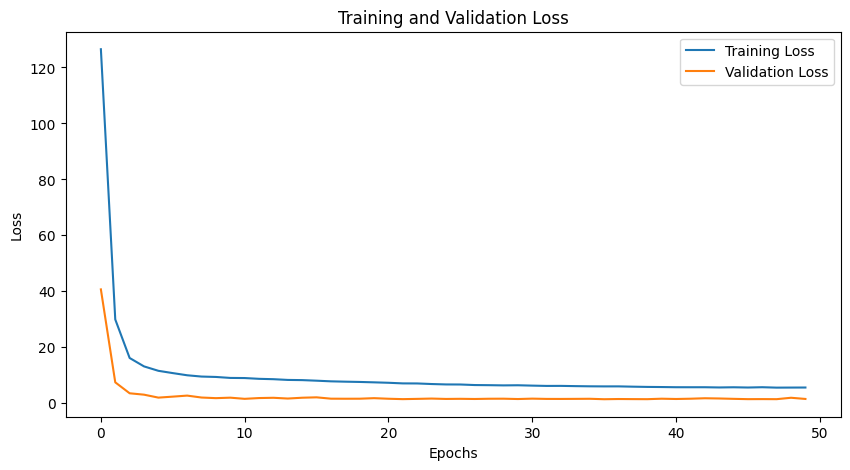

In [16]:
# In kết quả loss
print("Training Losses:", train_losses)
print("Validation Losses:", val_losses)

# Vẽ biểu đồ để trực quan hóa loss
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [17]:
# Đánh giá mô hình trên tập validation
val_loss, _ = evaluate(
    model,          # Mô hình đã huấn luyện
    val_loader,     # DataLoader của tập validation
    criterion,      # Hàm mất mát (MSELoss)
    device          # Thiết bị (CPU hoặc GPU)
)

# Đánh giá mô hình trên tập test
test_loss, _ = evaluate(
    model,          # Mô hình đã huấn luyện
    test_loader,    # DataLoader của tập test
    criterion,      # Hàm mất mát (MSELoss)
    device          # Thiết bị (CPU hoặc GPU)
)

# In kết quả đánh giá
print('Evaluation on validation and test datasets')
print(f'Validation Loss: {val_loss:.4f}')
print(f'Test Loss: {test_loss:.4f}')


Evaluation on validation and test datasets
Validation Loss: 1.5435
Test Loss: 1.3666


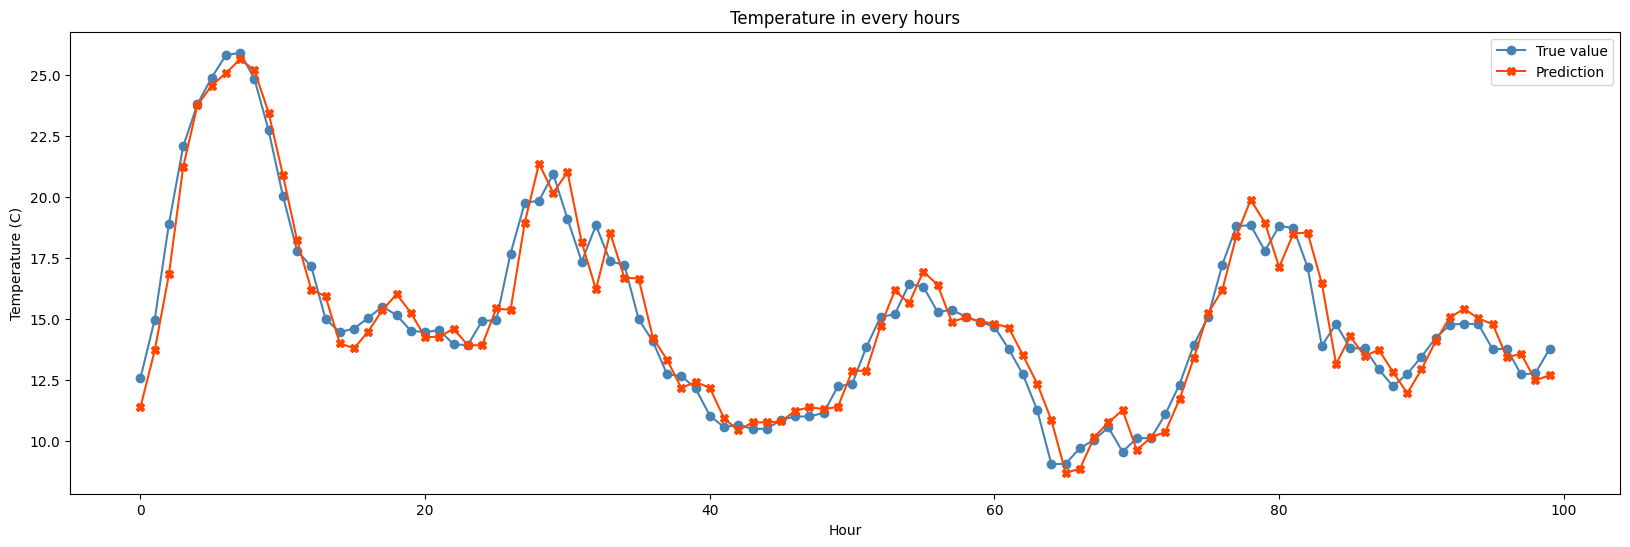

In [18]:
import matplotlib.pyplot as plt

def plot_difference(y, pred):
    """
    Hàm vẽ biểu đồ so sánh giá trị thực tế và dự đoán.

    Args:
        y (numpy array): Giá trị thực tế.
        pred (numpy array): Giá trị dự đoán.
    """
    plt.figure(figsize=(20, 6))  # Kích thước biểu đồ
    times = range(len(y))       # Trục thời gian
    y_to_plot = y.flatten()     # Làm phẳng mảng giá trị thực tế
    pred_to_plot = pred.flatten()  # Làm phẳng mảng giá trị dự đoán

    # Vẽ giá trị thực tế
    plt.plot(times, y_to_plot, color='steelblue', marker='o', label='True value')
    # Vẽ giá trị dự đoán
    plt.plot(times, pred_to_plot, color='orangered', marker='X', label='Prediction')

    # Thêm tiêu đề và nhãn
    plt.title('Temperature in every hours')
    plt.xlabel('Hour')
    plt.ylabel('Temperature (C)')
    plt.legend()  # Hiển thị chú thích
    plt.show()    # Hiển thị biểu đồ

# Lấy dữ liệu đầu vào từ tập test
inputs = torch.tensor(X_test[:100], dtype=torch.float32).to(device)  # Lấy 100 mẫu đầu tiên

# Chuyển mô hình sang chế độ đánh giá
model.eval()
with torch.no_grad():  # Tắt gradient để dự đoán
    outputs = model(inputs).detach().cpu().numpy()  # Dự đoán và chuyển kết quả về numpy

# Vẽ biểu đồ so sánh giá trị thực tế và dự đoán
plot_difference(y_test[:100], outputs)
